In [3]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import csv
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score


# 3D to 2D conversion

Different ideas for 3D to 2D:
- MIP over tumor range
- Mean IP over image
- slice at center of tumor
- Image x Mask MIP


### load an image


In [2]:
image = sitk.ReadImage('c:/users/sven/Documents/BEP/simplified_data\B12\IMAGES\B12.nii.gz')
img_data = sitk.GetArrayFromImage(image)

mask = sitk.ReadImage('c:/users/sven/Documents/BEP/simplified_data\B12\MASKS\B12.nii.gz')
mask_data = sitk.GetArrayFromImage(mask)

### MIP over tumor range

#### Tumor range


In [5]:
def tumor_range(mask: np.ndarray)->tuple:
    """ Find the start and end z-value of the tumor using the mask.
    
    """
    non_zero_rows = np.any(mask, axis=(1, 2))
    first_non_zero_row = np.argmax(non_zero_rows)
    last_non_zero_row = mask_data.shape[0] - 1 - np.argmax(non_zero_rows[::-1])
    
    return first_non_zero_row, last_non_zero_row
    

#### Crop image over tumor range

In [6]:
def crop_image_tr(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """Crop the image according to the tumor range."""
    x1, x2 = tumor_range(mask)
    if x2 < x1:
        x1, x2 = x2, x1
    cropped_image = image[x1:x2+1, :, :]

    return cropped_image

#### Maximum intensity projection

In [7]:
def mip_tr(image: np.ndarray, mask: np.ndarray)->np.ndarray:
    """Create the maximum intensity projection.
    """
    #cropped_image = crop_image_tr(image,mask)
    #print(np.shape(cropped_image))
    return np.max(image, axis=0)

#### visualization

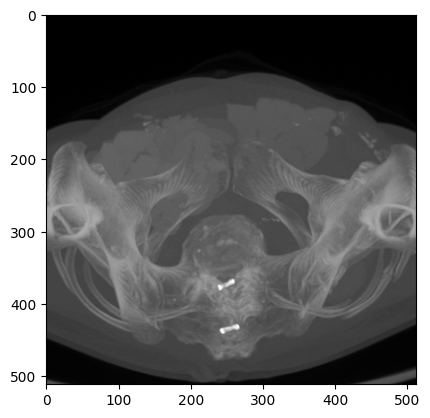

In [8]:
plt.imshow(mip_tr(img_data,mask_data), cmap='gray')
plt.show()

### Mean image projection


In [9]:
def mean_ip(image: np.ndarray)->np.ndarray:
    """Create a mean image projection.
    """
    return np.mean(image,axis=0)

#### Visualization

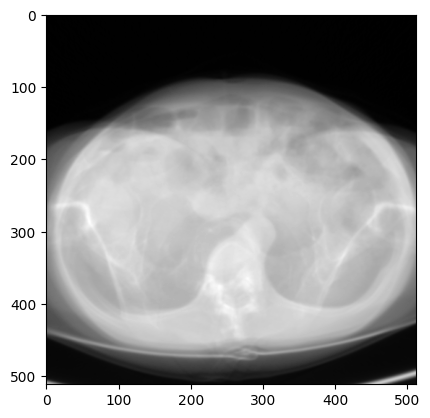

In [10]:
plt.imshow(mean_ip(img_data), cmap='gray')
plt.show()

### Slice at center of tumor

In [11]:
def find_tumor_center(mask: np.ndarray)->int:
    """Find the center of the tumor. 
    """
    
    return np.argmax(np.sum(mask, axis=(1, 2)))

In [12]:
def slice_tumor_center(image: np.ndarray, mask: np.ndarray)->np.ndarray:
    """Take a slice at the center of the tumor.
    """
    x1 = find_tumor_center(mask)
    return image[x1, :, :]

#### Visualization

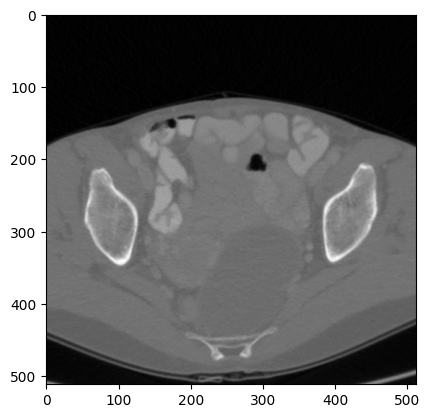

In [13]:
plt.imshow(slice_tumor_center(img_data, mask_data), cmap='gray')
plt.show()

### Image x Mask MIP

In [14]:
def tumor_mip(image: np.ndarray, mask: np.ndarray)->np.ndarray:
    """Return the mip of the tumor only.
    """
    
    return np.max(image * mask, axis=0)

#### Visualization

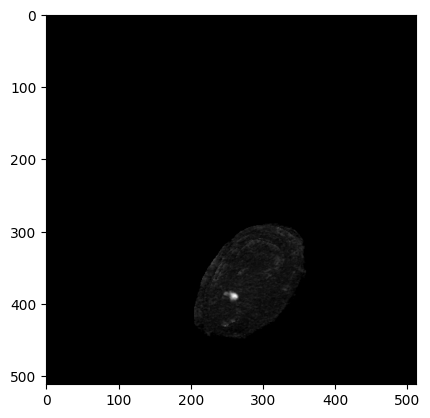

In [15]:
plt.imshow(tumor_mip(img_data, mask_data), cmap='gray')
plt.show()

# Resnet50 feature extraction

#### Create input

In [16]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

#### Load the model

In [22]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.eval()



EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

#### Feature extraction function

In [23]:
def feature_extraction(input_array: np.ndarray)-> np.ndarray:
    # Convert numpy array to torch tensor and normalize
    input_tensor = torch.from_numpy(np.transpose(input_array, (2, 0, 1))).float()
    input_tensor /= 255.0
    input_tensor = input_tensor.unsqueeze(0)

    # Extract features using ResNet50
    with torch.no_grad():
        features = model.forward_features(input_tensor)
        features = torch.mean(features, dim=[2, 3])

    # Convert features to numpy array
    features_array = features.numpy()#.reshape(1, -1)
    
    return features_array

In [24]:
def input_array_creation(layout, image, mask): 
    
    if layout[0] == 1:
        slot_1 = mip_tr(image,mask)
    elif layout[0] == 2:
        slot_1 = mean_ip(image)
    elif layout[0] == 3:
        slot_1 = slice_tumor_center(image,mask)
    elif layout[0] == 4:
        slot_1 = tumor_mip(image,mask)
    
        
    if layout[1] == 1:
        slot_2 = mip_tr(image,mask)
    elif layout[1] == 2:
        slot_2 = mean_ip(image)
    elif layout[1] == 3:
        slot_2 = slice_tumor_center(image,mask)
    elif layout[1] == 4:
        slot_2 = tumor_mip(image,mask)
        
        
    if layout[2] == 1:
        slot_3 = mip_tr(image,mask)
    elif layout[2] == 2:
        slot_3 = mean_ip(image)
    elif layout[2] == 3:
        slot_3 = slice_tumor_center(image,mask)
    elif layout[2] == 4:
        slot_3 = tumor_mip(image,mask)
        

    
    #plt.imshow(slot_1, cmap='gray')
    #plt.show()
    
    return np.dstack((slot_1, slot_2, slot_3)) 

In [25]:
def feature_extraction_full(layout):

    result = np.empty((0, 1280))


    with open('c:/users/sven/Documents/BEP_sbierenbroodspot_1334859/Pyradiomics/v5/folderNames2.csv', newline='') as file:
        reader = csv.reader(file)

        next(reader)

        for row in reader:
            
            image = sitk.ReadImage(row[1])
            img_data = sitk.GetArrayFromImage(image)

            mask = sitk.ReadImage(row[2])
            mask_data = sitk.GetArrayFromImage(mask)
            #print(np.shape(crop_image_tr(img_data, mask_data)))
            #print(row)
            
            result_vector = feature_extraction(input_array_creation(layout, img_data, mask_data))
            result = np.vstack([result, result_vector])
            
    return result

       
        
        
        


In [46]:

result  = feature_extraction_full([1, 1, 1])
svm_auc_max(result, labels)

0.4657575757575758

In [ ]:
feature_extraction(np.dstack((mip_tr(img_data,mask_data), mip_tr(img_data,mask_data), mip_tr(img_data,mask_data))) )




In [ ]:
feature_extraction(input_array_creation([1,1,1], img_data, mask_data))

In [ ]:
np.shape(result)

In [25]:
np.savetxt("result.csv", result, delimiter=",")

#### Create labels


In [35]:
labels = np.empty((0,0))
with open('c:/users/sven/Documents/BEP_sbierenbroodspot_1334859/Technical_research/Labels.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        labels = np.append(labels, row[0])

labels
        

array(['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'],
      dtype='<U32')

# SVM


In [31]:

def svm_auc(data: np.ndarray, labels: np.ndarray)->np.float64:


    # Create a stratified 5-fold cross-validation object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize an SVM classifier
    svm = SVC(kernel='linear', probability=True)

    # Store the AUC scores
    auc_scores = []

    # Perform cross-validation
    for train_idx, test_idx in cv.split(data, labels):
        # Split the data and labels
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Train the SVM classifier
        svm.fit(X_train, y_train)

        # Predict the probabilities for the test set
        y_pred_proba = svm.predict_proba(X_test)[:, 1]

        # Compute the AUC score
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Store the AUC score
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [32]:
def svm_auc_max(data: np.ndarray, labels: np.ndarray)->np.float64:
    # Initialize a variable to store the maximum output
    max_output = -np.inf

    # Iterate over the function 20 times
    for i in range(100):
        # Compute the output of the function
        output = svm_auc(data, labels)

        # Update the maximum output if necessary
        if output > max_output:
            max_output = output
    return max_output
    
    

In [44]:
svm_auc_max(result, labels)

0.5030303030303032

In [47]:
for i in range(1, 5):
    for j in range(1, 5):
        for k in range(1, 5):
            my_list = [i, j, k]
            auc = svm_auc_max(feature_extraction_full(my_list),labels)
            print(my_list, auc)

[1, 1, 1] 0.4536363636363637
[1, 1, 2] 0.6142424242424241
[1, 1, 3] 0.5927272727272727
[1, 1, 4] 0.5963636363636364
[1, 2, 1] 0.5206060606060606
[1, 2, 2] 0.5822222222222222
[1, 2, 3] 0.555959595959596
[1, 2, 4] 0.6274747474747475
[1, 3, 1] 0.505050505050505
[1, 3, 2] 0.6290909090909091
[1, 3, 3] 0.5593939393939394
[1, 3, 4] 0.5545454545454546
[1, 4, 1] 0.5969696969696969
[1, 4, 2] 0.6614141414141415
[1, 4, 3] 0.5593939393939393
[1, 4, 4] 0.5802020202020202
[2, 1, 1] 0.49333333333333335
[2, 1, 2] 0.6084848484848485
[2, 1, 3] 0.5442424242424242
[2, 1, 4] 0.5966666666666667
[2, 2, 1] 0.5971717171717172
[2, 2, 2] 0.5656565656565655
[2, 2, 3] 0.5719191919191918
[2, 2, 4] 0.5511111111111111
[2, 3, 1] 0.5096969696969698
[2, 3, 2] 0.5912121212121212
[2, 3, 3] 0.6504040404040404
[2, 3, 4] 0.5618181818181818
[2, 4, 1] 0.5848484848484848
[2, 4, 2] 0.5684848484848486
[2, 4, 3] 0.6050505050505051
[2, 4, 4] 0.5926262626262627
[3, 1, 1] 0.5648484848484848
[3, 1, 2] 0.5913131313131312
[3, 1, 3] 0.592

# More efficient way


In [19]:
MIP_list = []
AIP_list = []
SLICE_list = []
TUMOR_MIP_list = []

with open('c:/users/sven/Documents/BEP_sbierenbroodspot_1334859/Pyradiomics/v5/folderNames2.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)
    
    for row in reader:
        image = sitk.ReadImage(row[1])
        img_data = sitk.GetArrayFromImage(image)

        mask = sitk.ReadImage(row[2])
        mask_data = sitk.GetArrayFromImage(mask)

        MIP_list.append(mip_tr(img_data,mask_data))
        AIP_list.append(mean_ip(img_data))
        SLICE_list.append(slice_tumor_center(img_data,mask_data))
        TUMOR_MIP_list.append(tumor_mip(img_data,mask_data))

In [26]:
def input_array_creation_v2(layout, i): 
    
    if layout[0] == 1:
        slot_1 = MIP_list[i]
    elif layout[0] == 2:
        slot_1 = AIP_list[i]
    elif layout[0] == 3:
        slot_1 = SLICE_list[i]
    elif layout[0] == 4:
        slot_1 = TUMOR_MIP_list[i]
    
        
    if layout[1] == 1:
        slot_2 = MIP_list[i]
    elif layout[1] == 2:
        slot_2 = AIP_list[i]
    elif layout[1] == 3:
        slot_2 = SLICE_list[i]
    elif layout[1] == 4:
        slot_2 = TUMOR_MIP_list[i]
        
        
    if layout[2] == 1:
        slot_3 = MIP_list[i]
    elif layout[2] == 2:
        slot_3 = AIP_list[i]
    elif layout[2] == 3:
        slot_3 = SLICE_list[i]
    elif layout[2] == 4:
        slot_3 = TUMOR_MIP_list[i]
    
    return np.dstack((slot_1, slot_2, slot_3)) 

In [29]:
def feature_extraction_full(layout):

    result = np.empty((0, 1280))

    for i in range(len(MIP_list)):
        result_vector = feature_extraction(input_array_creation_v2(layout, i))
        result = np.vstack([result, result_vector])    
    return result

       

In [36]:
result  = feature_extraction_full([1, 1, 1])
svm_auc_max(result, labels)

0.4641414141414142